# Introduction

There is a lot of information on runners and their performance for the Boston Marathon. Pick a year (post-2012 has more info) and do some clustering.

Specifically, use the tools at hand to determine which clustering solution, including number of clusters and algorithm used, is best for the marathon data. Once you have a solution you like, write a data story, including visualizations, where you teach the reader something about the Boston Marathon based on your clusters.

### Imports

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
%matplotlib inline

# Options for pandas
pd.options.display.max_columns = 150
pd.options.display.max_rows = 150

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1.0.1"><span class="toc-item-num">1.0.1&nbsp;&nbsp;</span>Imports</a></span></li></ul></li></ul></li><li><span><a href="#K-Means" data-toc-modified-id="K-Means-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>K-Means</a></span></li></ul></div>

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/llimllib/bostonmarathon/master/results/2014/results.csv')

In [3]:
df.head()

,10k,name,division,25k,gender,age,official,bib,genderdiv,ctz,35k,overall,pace,state,30k,5k,half,20k,country,city,40k
0,17.37,"Yamamoto, Hiroyuki",8,47.67,M,47,85.25,W1,8,NaN,71.40,8,3.27,NaN,59.18,8.02,39.72,37.65,JPN,Fukuoka,80.43
1,32.58,"Jeptoo, Rita",1,82.43,F,33,138.95,F1,1,NaN,116.37,21,5.30,NaN,99.33,16.22,69.47,65.83,KEN,Eldoret,132.10
2,16.62,"Van Dyk, Ernst F.",1,45.80,M,41,80.60,W2,1,NaN,67.42,1,3.08,NaN,56.45,7.75,38.03,36.10,RSA,Paarl,76.10
3,32.57,"Dibaba, Mare",3,82.43,F,24,140.58,F2,3,NaN,116.37,27,5.37,NaN,99.33,16.20,69.47,65.83,ETH,Shoa,132.95
4,17.12,"Hokinoue, Kota",2,46.37,M,40,81.23,W3,2,NaN,67.83,2,3.10,NaN,57.03,8.02,38.60,36.58,JPN,Nogata Fukuoka,76.72


In [4]:
df.describe()

,division,age,official,genderdiv,overall,pace
count,31984.000000,31984.000000,31984.000000,31984.000000,31984.000000,31984.000000
mean,1932.563032,42.407079,242.997314,8051.044741,15939.587825,9.275658
std,1715.228694,11.316496,52.300431,4754.005626,9232.978224,1.992486
min,1.000000,18.000000,80.600000,1.000000,1.000000,3.080000
25%,610.000000,33.000000,205.527500,3972.000000,7943.750000,7.850000
50%,1425.000000,42.000000,232.370000,7970.000000,15939.500000,8.870000
75%,2611.000000,50.000000,273.235000,11968.000000,23935.250000,10.430000
max,6979.000000,81.000000,538.880000,17575.000000,31931.000000,20.570000


In [5]:
df.isnull().sum() / df.isnull().count()

10k          0.000000
name         0.000000
division     0.000000
25k          0.000000
gender       0.000000
age          0.000000
official     0.000000
bib          0.000000
genderdiv    0.000000
ctz          0.961106
35k          0.000000
overall      0.000000
pace         0.000000
state        0.080540
30k          0.000000
5k           0.000000
half         0.000000
20k          0.000000
country      0.000000
city         0.000031
40k          0.000000
dtype: float64

In [6]:
df.dtypes

10k           object
name          object
division       int64
25k           object
gender        object
age            int64
official     float64
bib           object
genderdiv      int64
ctz           object
35k           object
overall        int64
pace         float64
state         object
30k           object
5k            object
half          object
20k           object
country       object
city          object
40k           object
dtype: object

In [7]:
#drop ctz since 96% are null and drop name since names are all distinct
df.drop(['ctz', 'name'], axis=1, inplace=True)

df.dropna(subset=['city','state'], inplace=True)

#drop observations with '-' in time columns
df = df[(df['5k'] != '-') & (df['10k'] != '-') & (df['20k'] != '-') & (df['25k'] != '-') & 
        (df['30k'] != '-') & (df['35k'] != '-') & (df['40k'] != '-') & (df['half'] != '-')]

#convert numerical columns to float
for col in df.columns:
    if df[col].dtypes == 'object':
        try:
            df[col] = df[col].astype('float')
        except TypeError:
            continue
        except ValueError:
            continue


In [8]:
df.dtypes

10k          float64
division       int64
25k          float64
gender        object
age            int64
official     float64
bib           object
genderdiv      int64
35k          float64
overall        int64
pace         float64
state         object
30k          float64
5k           float64
half         float64
20k          float64
country       object
city          object
40k          float64
dtype: object

In [9]:
categorical_list = [col for col in df.columns if df[col].dtypes == 'O']
df = pd.merge(df.loc[:, ~df.columns.isin(categorical_list)], pd.get_dummies(df['gender']), left_index=True, right_index=True)

In [10]:
df.head()

,10k,division,25k,age,official,genderdiv,35k,overall,pace,30k,5k,half,20k,40k,F,M
9,30.48,20,77.68,31,137.83,20,112.27,20,5.27,94.78,15.15,65.23,61.78,129.83,0,1
14,17.12,13,48.88,29,87.40,13,72.83,13,3.35,60.82,8.02,40.20,38.02,82.38,0,1
15,33.93,10,85.03,30,143.90,10,119.68,46,5.50,102.40,16.92,71.68,67.92,136.47,1,0
24,18.30,14,50.33,47,89.40,14,74.95,14,3.42,62.33,8.67,41.80,39.63,84.48,0,1
27,18.78,15,50.33,30,89.52,15,75.02,15,3.42,62.72,8.98,41.82,39.65,84.75,0,1


# K-Means

In [11]:
data = normalize(df)
#data = PCA(11).fit_transform(data)

y_pred = KMeans(n_clusters=4, random_state=42).fit_predict(data)

In [12]:
plot_list = ['division', 'age', 'official', 'genderdiv', 'overall', 'pace',  'half',
 '40k']

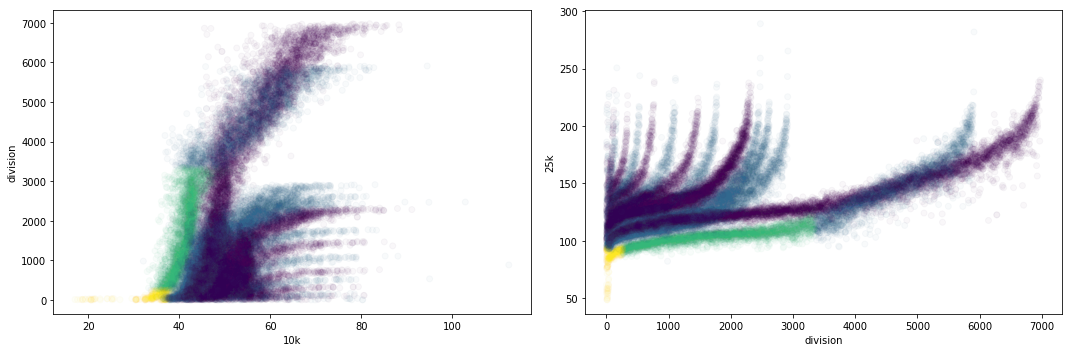

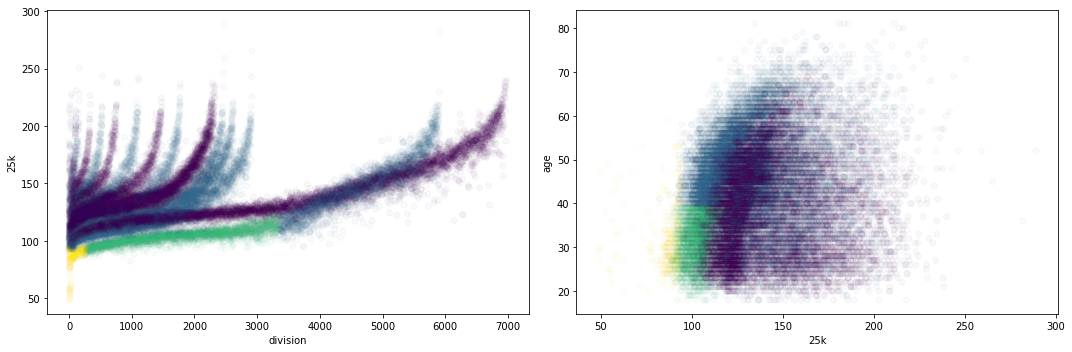

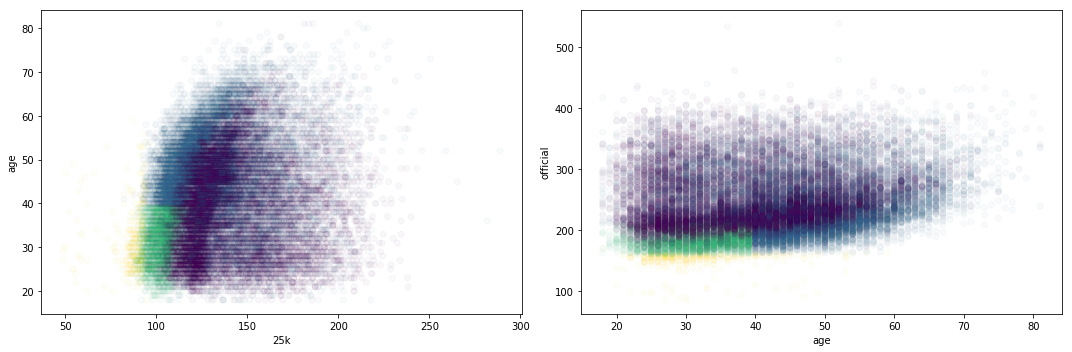

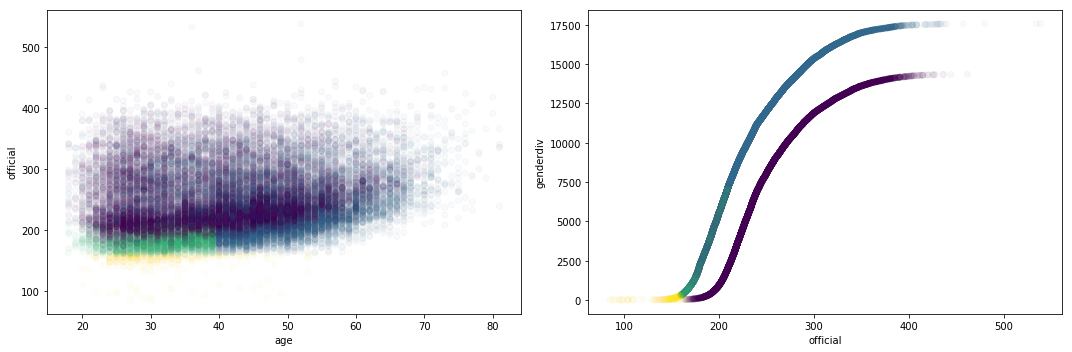

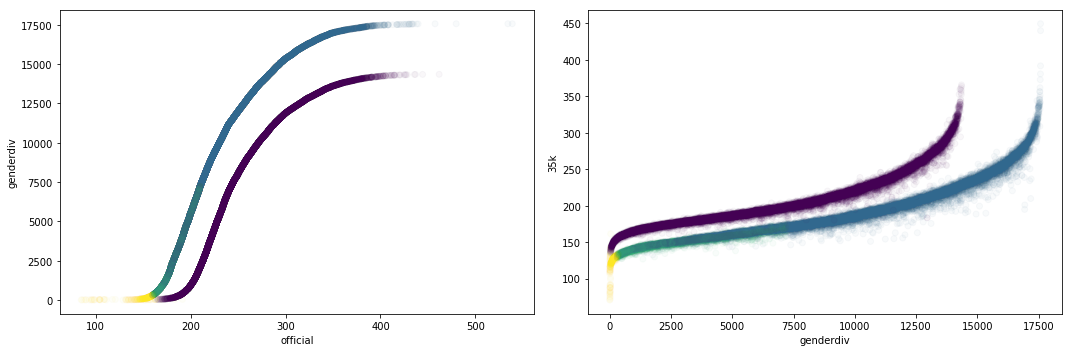

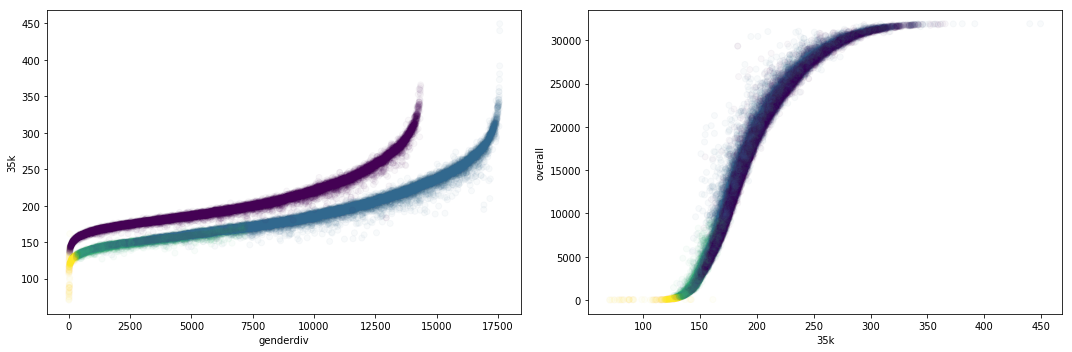

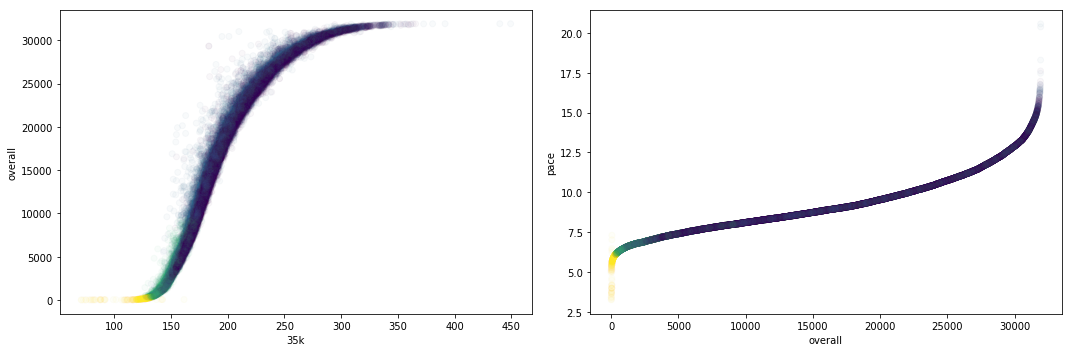

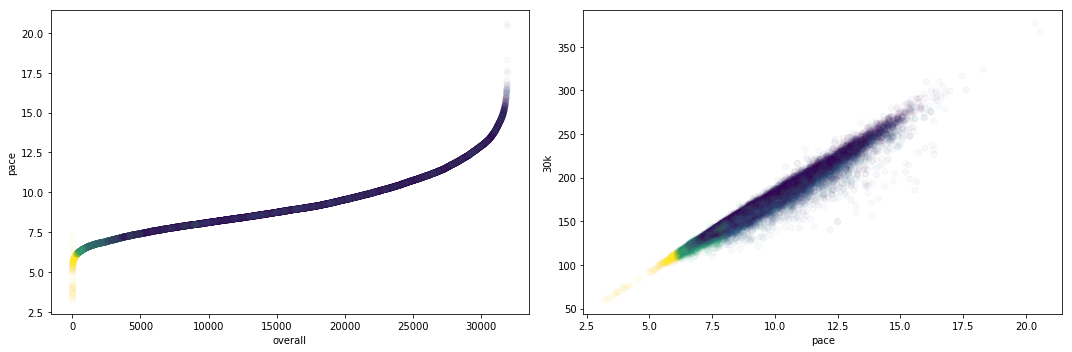

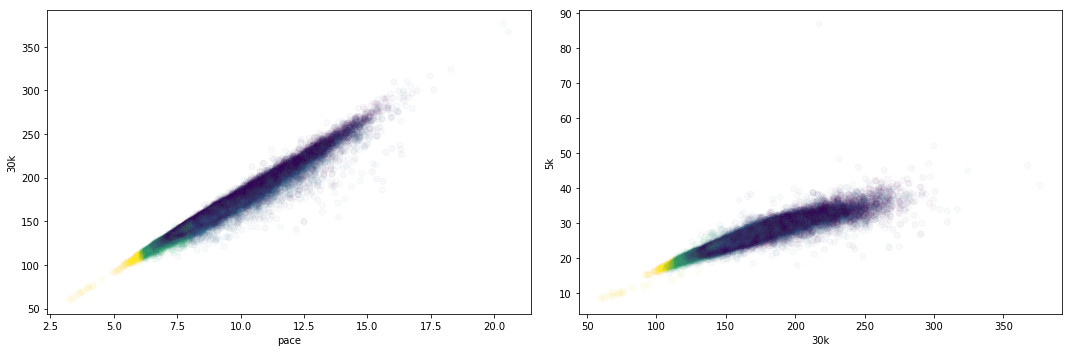

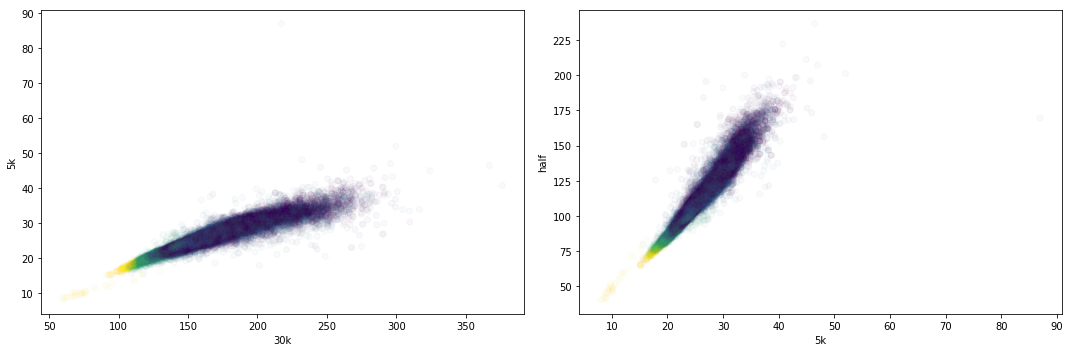

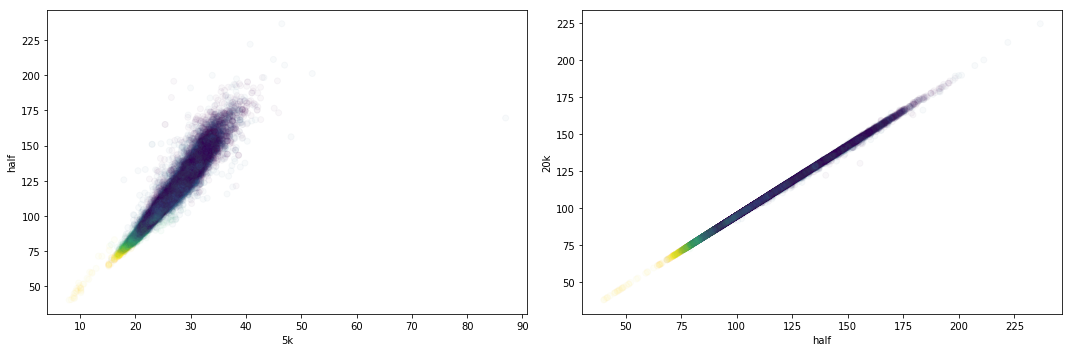

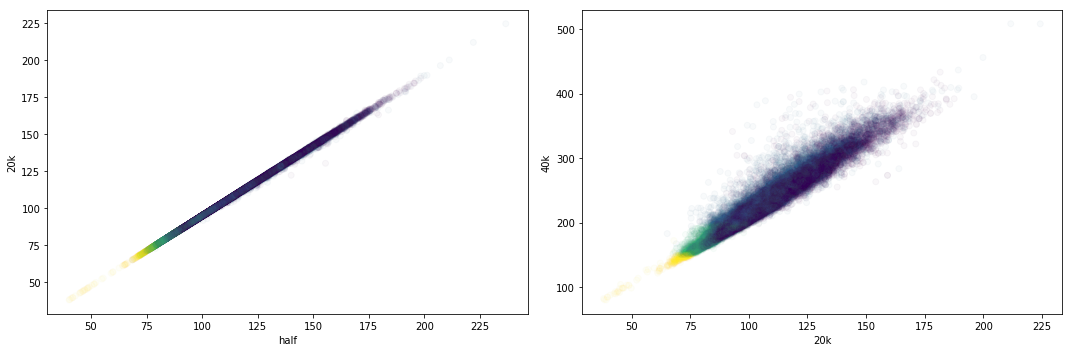

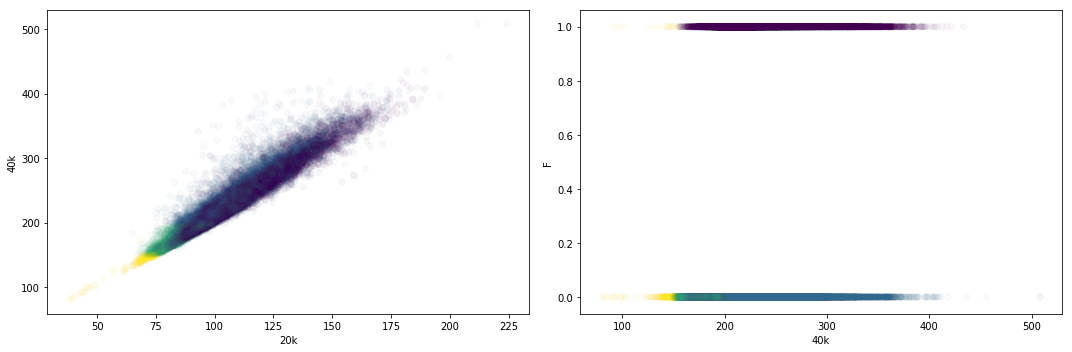

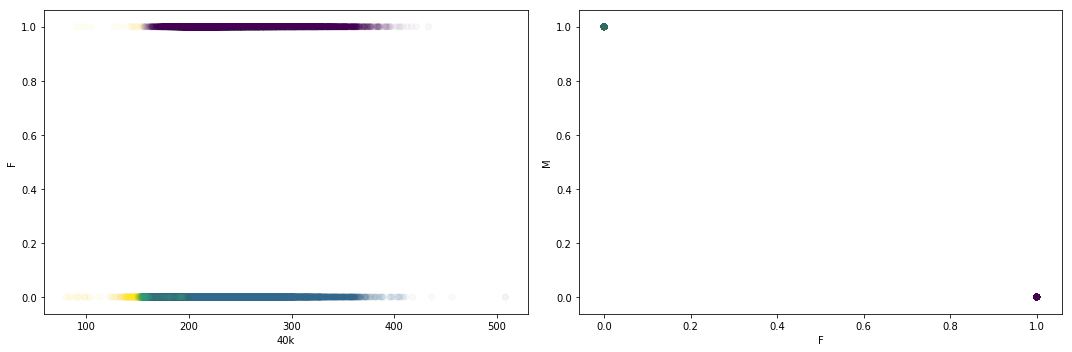

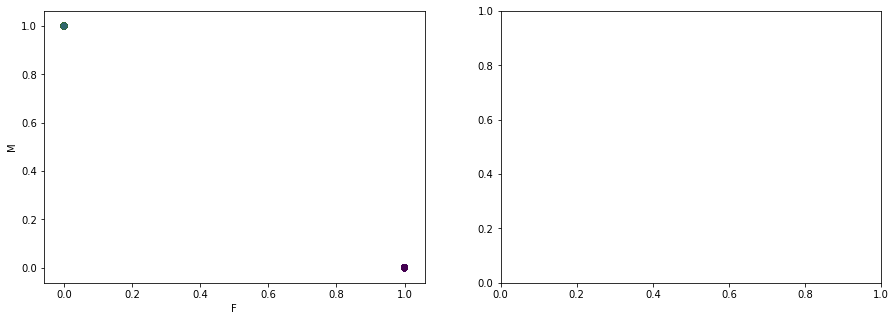

In [21]:
feature_list = list(df.columns)
for i,_ in enumerate(feature_list):
    plt.figure(figsize=(15,5))
    plt.subplot(1, 2, 1)
    plt.scatter(df[feature_list[i]], df[feature_list[i+1]], c=y_pred, alpha=.03)
    plt.xlabel(feature_list[i])
    plt.ylabel(feature_list[i+1])
    
    plt.subplot(1, 2, 2)
    try:
        plt.scatter(df[feature_list[i+1]], df[feature_list[i+2]], c=y_pred, alpha=.03)
        plt.xlabel(feature_list[i+1])
        plt.ylabel(feature_list[i+2])
        plt.tight_layout()
        plt.show()
    except IndexError:
        break

Look as though K-means clustered the observations by distance times. There's a somewhat clear separation between the two clusters with lower distance times (yellow and green clusters) and no clear separation between the two clusters with higher distance times (purple and blue clusters). This could mean that runners with higher distance times have more variance between other features. For example, the range of 40k times is larger for older people than younger runners. 